<a href="https://colab.research.google.com/github/catastropiyush/coursework-notebooks/blob/main/Copy_of_Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# see: http://lukemetz.com/exploring-hyperparameter-meta-loss-landscapes-with-jax/ for more info

In [ ]:
# # Make sure the Colab Runtime is set to Accelerator: TPU.
# # This is boilerplate needed to leverage TPU's (though this notebook will run fine on any hardware.)
# import requests
# import os
# if 'TPU_DRIVER_MODE' not in globals():
#   url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
#   resp = requests.post(url)
#   TPU_DRIVER_MODE = 1

# # The following is required to use TPU Driver as JAX's backend.
# from jax.config import config
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
# print(config.FLAGS.jax_backend_target)

grpc://10.101.64.122:8470


In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
!pip install smplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [ ]:
import jax
import jax.tools.colab_tpu
import jax.numpy as jnp
from matplotlib import pylab as plt

Text(0, 0.5, 'inner-loss')

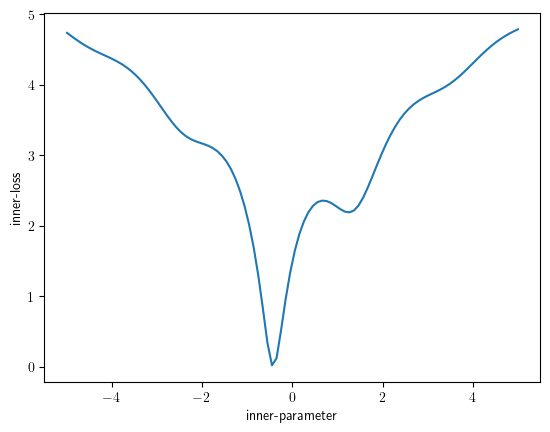

In [ ]:
@jax.jit
def inner_loss(x):
  #return jnp.log(x**2 + 1.0 + jnp.sin(x*3)*0.5) + 1.5
  return jnp.log(x**2 + 1.0 + jnp.sin(x*3)) + 1.5

xs = jnp.linspace(-5, 5, 100)
plt.plot(xs, jax.vmap(inner_loss)(xs))
plt.xlabel("inner-parameter")
plt.ylabel("inner-loss")

Text(0, 0.5, 'inner-loss')

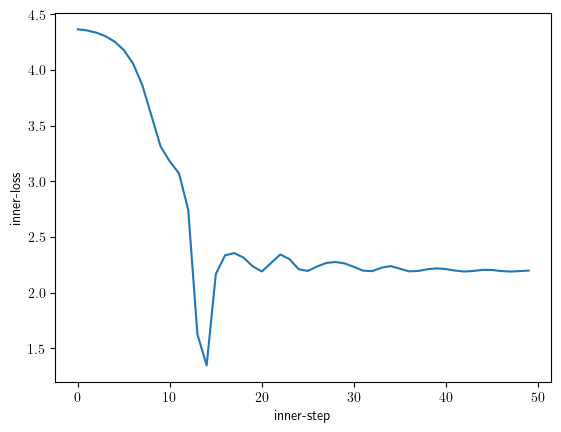

In [ ]:
x = -4. # initial inner parameter
v = 0.0 # initial momentum accumulator

lr = 0.1
mom = 0.9

value_and_grad_fn = jax.jit(jax.value_and_grad(inner_loss))

losses = []
for i in range(50):
  loss, grad = value_and_grad_fn(x)
  v= mom*v + grad
  x = x - lr * v
  losses.append(loss)
plt.plot(losses)
plt.xlabel("inner-step")
plt.ylabel("inner-loss")

In [ ]:
@jax.jit
def outer_loss(lr, mom):
  value_and_grad_fn = jax.jit(jax.value_and_grad(inner_loss))

  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

outer_loss(0.1, 0.9)

Array(2.6116986, dtype=float32)

Text(0, 0.5, 'outer-loss')

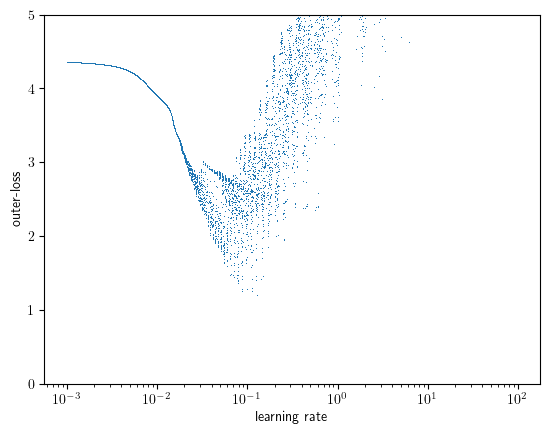

In [ ]:
lrs = jnp.logspace(-3, 2, 10000)
plt.semilogx(lrs, jax.jit(jax.vmap(outer_loss, in_axes=(0, None)))(lrs, 0.9), ",")
plt.ylim(0.0, 5.0)
plt.xlabel("learning rate")
plt.ylabel("outer-loss")

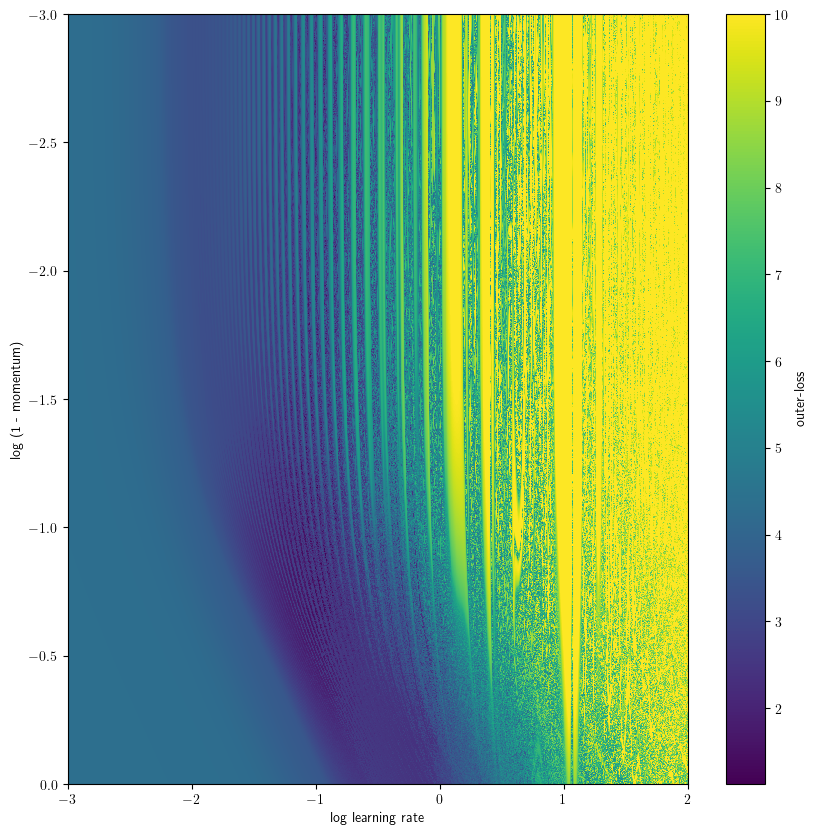

In [ ]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img_fn = jax.vmap(jax.vmap(outer_loss))

plt.figure(figsize=(10,10))
img = img_fn(lrs, moms)

plt.imshow(img, extent=[-3, 2, 0, -3], aspect="auto", interpolation="nearest", vmax=10)
plt.xlabel("log learning rate")
plt.ylabel("log (1 - momentum)")
cbar = plt.colorbar()
cbar.set_label("outer-loss")

# Good init

In [ ]:
@jax.jit
def outer_loss(outer_params):
  log_lr, one_minus_log_mom = outer_params
  lr = jnp.power(10, log_lr)
  mom = 1.0 - jnp.power(10, one_minus_log_mom)
  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

outer_grad_fn = jax.jit(jax.value_and_grad(outer_loss))


outer_params = (-2., -0.5)

outer_params_traj = [outer_params]

losses = []
grads = []
alpha = 0.01
for i in range(100):
  loss, outer_grad = outer_grad_fn(outer_params)
  grads.append(outer_grad)
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)
  outer_params = jax.tree_util.tree_map(lambda a,b: a-alpha*b, outer_params, outer_grad)
  outer_params_traj.append(outer_params)
  losses.append(loss)


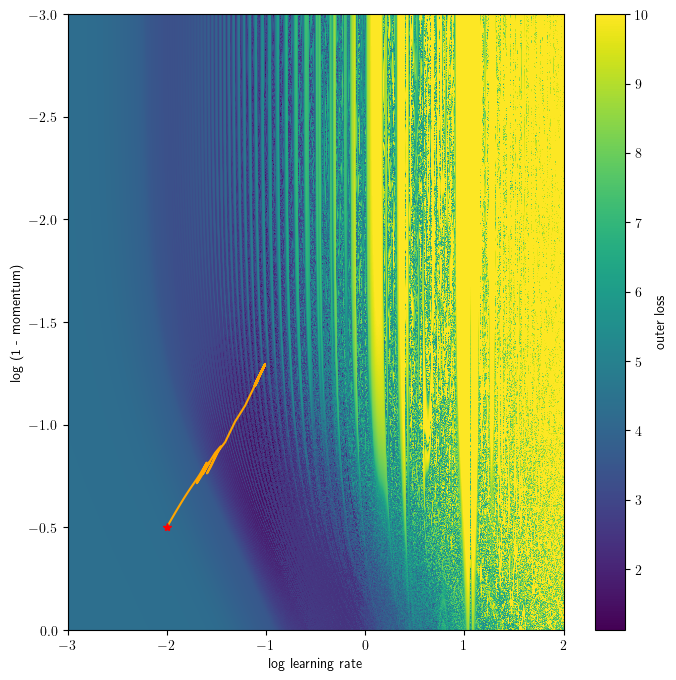

In [ ]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img = img_fn(lrs, moms)
plt.figure(figsize=(8,8))

plt.imshow(img, extent=[-3, 2, 0, -3], interpolation="nearest", vmax=10, aspect="auto")
plt.xlabel("log learning rate")
plt.ylabel("log (1 - momentum)")
cbar = plt.colorbar()
cbar.set_label("outer loss")

log_lrs, one_minus_log_moms = list(zip(*outer_params_traj))
plt.plot(log_lrs[0:1000], one_minus_log_moms[0:1000], "-", color="orange")
plt.plot(log_lrs[0:1], one_minus_log_moms[0:1], "*", color="red")

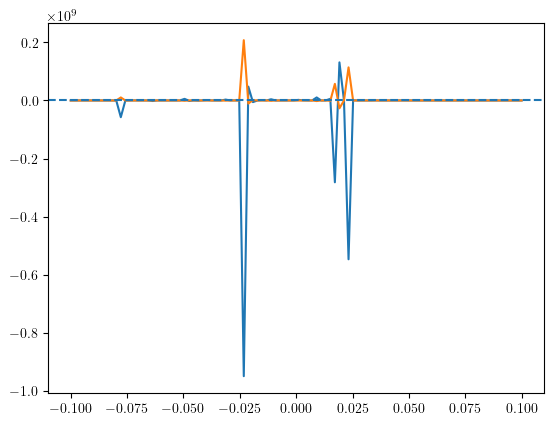

In [ ]:
ts = jnp.linspace(-0.1, 0.1, 100)
ggs = jax.jit(jax.vmap(jax.grad(outer_loss), in_axes=((None, 0), )))((outer_params[0], outer_params[1] + ts))
g_lr, g_mom = ggs
plt.plot(ts, g_lr)
plt.plot(ts, g_mom)
plt.axhline(y=0, linestyle="--")

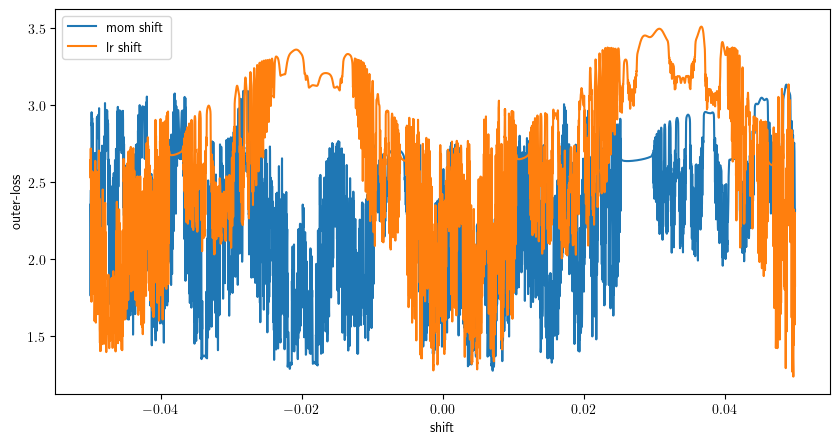

In [ ]:
plt.figure(figsize=(10, 5))

ts = jnp.linspace(-0.05, 0.05, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((None, 0), )))((outer_params[0], outer_params[1] + ts))
plt.plot(ts, vs, label="mom shift")

ts = jnp.linspace(-0.05, 0.05, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((0, None), )))((outer_params[0]+ts, outer_params[1]))
plt.plot(ts, vs, label="lr shift")

plt.ylabel("outer-loss")
plt.xlabel("shift")
plt.legend()

# Bad init

In [ ]:
@jax.jit
def outer_loss(outer_params):
  log_lr, one_minus_log_mom = outer_params
  lr = jnp.power(10, log_lr)
  mom = 1.0 - jnp.power(10, one_minus_log_mom)
  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

outer_grad_fn = jax.jit(jax.value_and_grad(outer_loss))


outer_params = (0., -1.5)
clip_params = [outer_params]

losses = []
grads = []
alpha = 0.01
for i in range(500):
  loss, outer_grad = outer_grad_fn(outer_params)
  grads.append(outer_grad)
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)
  outer_params = jax.tree_util.tree_map(lambda a,b: a-alpha*b, outer_params, outer_grad)
  clip_params.append(outer_params)
  losses.append(loss)
  print(loss, outer_params, outer_grad)


7.059841 (Array(-0.09999999, dtype=float32, weak_type=True), Array(-1.4, dtype=float32, weak_type=True)) (Array(10., dtype=float32, weak_type=True), Array(-10., dtype=float32, weak_type=True))
8.649832 (Array(-0.19999999, dtype=float32, weak_type=True), Array(-1.3744454, dtype=float32, weak_type=True)) (Array(10., dtype=float32, weak_type=True), Array(-2.555448, dtype=float32, weak_type=True))
4.6561704 (Array(-0.09999999, dtype=float32, weak_type=True), Array(-1.4744455, dtype=float32, weak_type=True)) (Array(-10., dtype=float32, weak_type=True), Array(10., dtype=float32, weak_type=True))
8.7992 (Array(-0.13198917, dtype=float32, weak_type=True), Array(-1.4594699, dtype=float32, weak_type=True)) (Array(3.1989174, dtype=float32, weak_type=True), Array(-1.4975537, dtype=float32, weak_type=True))
7.205737 (Array(-0.23198916, dtype=float32, weak_type=True), Array(-1.413809, dtype=float32, weak_type=True)) (Array(10., dtype=float32, weak_type=True), Array(-4.5661, dtype=float32, weak_type=

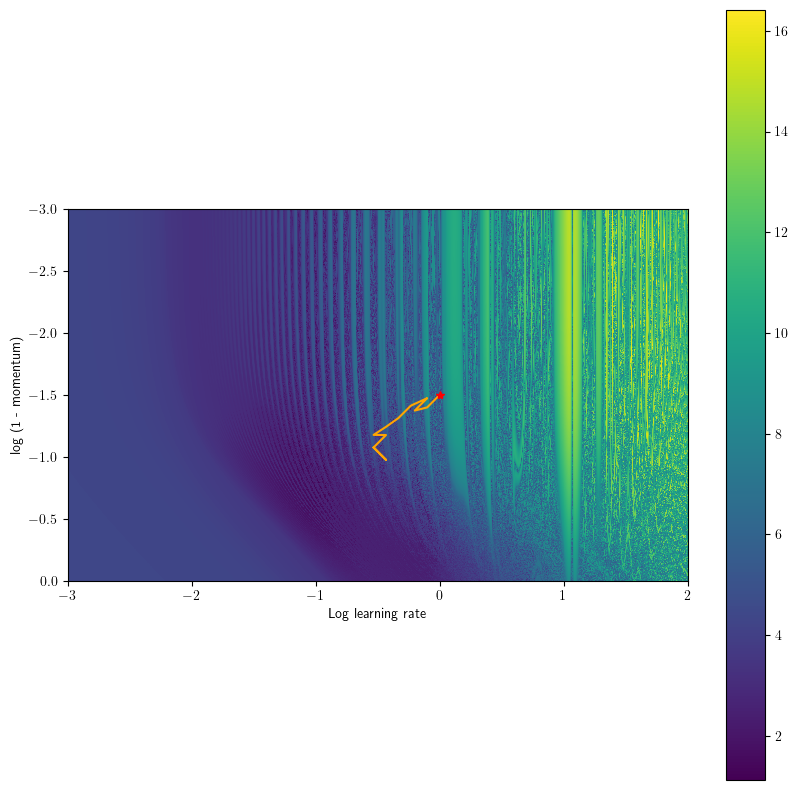

In [ ]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img = img_fn(lrs, moms)
plt.figure(figsize=(10,10))

plt.imshow(img, extent=[-3, 2, 0, -3], interpolation="nearest")
plt.xlabel("Log learning rate")
plt.ylabel("log (1 - momentum)")
plt.colorbar()

log_lrs, one_minus_log_moms = list(zip(*clip_params))
plt.plot(log_lrs[0:4000], one_minus_log_moms[0:4000], "-", color="orange")
plt.plot(log_lrs[0:1], one_minus_log_moms[0:1], "*", color="red")

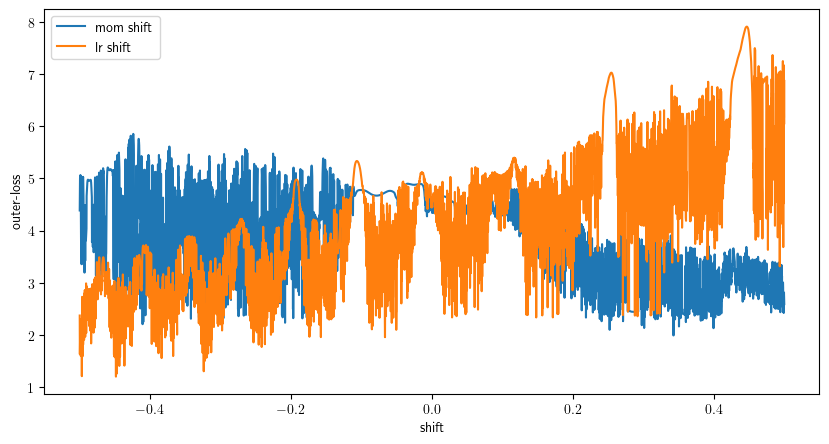

In [ ]:
plt.figure(figsize=(10, 5))

ts = jnp.linspace(-0.5, 0.5, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((None, 0), )))((outer_params[0], outer_params[1] + ts))
plt.plot(ts, vs, label="mom shift")

ts = jnp.linspace(-0.5, 0.5, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((0, None), )))((outer_params[0]+ts, outer_params[1]))
plt.plot(ts, vs, label="lr shift")

plt.ylabel("outer-loss")
plt.xlabel("shift")
plt.legend()

In [ ]:
@jax.jit
def outer_loss(outer_params):
  log_lr, one_minus_log_mom = outer_params
  lr = jnp.power(10, log_lr)
  mom = 1.0 - jnp.power(10, one_minus_log_mom)
  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

@jax.jit
def outer_gradient_es(outer_params, key, std):
  lr_noise, mom_noise = jax.random.normal(key, [2])*std
  outer_params_pos = (outer_params[0] + lr_noise, outer_params[1]+mom_noise)
  outer_params_neg = (outer_params[0] - lr_noise, outer_params[1]-mom_noise)
  pos_loss = outer_loss(outer_params_pos)
  neg_loss = outer_loss(outer_params_neg)

  factor = (pos_loss - neg_loss) / (2 * std**2)
  outer_grad = (lr_noise * factor, mom_noise * factor)
  return (pos_loss + neg_loss) / 2, outer_grad

@jax.jit
def batch_outer_gradient_es(outer_params, key):
  n_sample = 16
  losses, grads = jax.vmap(outer_gradient_es, in_axes=(None, 0))(outer_params, jax.random.split(key, n_sample))
  return jnp.mean(losses), jax.tree_map(lambda x: jnp.mean(x, axis=0), grads)

outer_params = (0., -1.5)
clip_params = [outer_params]

losses = []
grads = []
alpha = 0.003
key = jax.random.PRNGKey(0)
for i in range(1000):
  key, key1 = jax.random.split(key)
  std = 0.1

  loss, outer_grad = outer_gradient_es(outer_params, key1, std)

  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)

  grads.append(outer_grad)
  outer_params = jax.tree_util.tree_map(lambda a,b: a-alpha*b, outer_params, outer_grad)
  clip_params.append(outer_params)
  losses.append(loss)
  print(loss, outer_params, outer_grad)


7.461283 (Array(-0.03, dtype=float32), Array(-1.53, dtype=float32)) (Array(10., dtype=float32), Array(10., dtype=float32))
7.5792265 (Array(-0.06, dtype=float32), Array(-1.5570372, dtype=float32)) (Array(10., dtype=float32), Array(9.012403, dtype=float32))
7.681632 (Array(-0.09, dtype=float32), Array(-1.5270373, dtype=float32)) (Array(10., dtype=float32), Array(-10., dtype=float32))
7.54457 (Array(-0.12, dtype=float32), Array(-1.5231235, dtype=float32)) (Array(10., dtype=float32), Array(-1.304589, dtype=float32))
5.8287725 (Array(-0.13636637, dtype=float32), Array(-1.4975235, dtype=float32)) (Array(5.4554567, dtype=float32), Array(-8.533324, dtype=float32))
6.615924 (Array(-0.14732, dtype=float32), Array(-1.4675236, dtype=float32)) (Array(3.6512122, dtype=float32), Array(-10., dtype=float32))
6.327467 (Array(-0.16149724, dtype=float32), Array(-1.4975235, dtype=float32)) (Array(4.7257423, dtype=float32), Array(10., dtype=float32))
4.6756697 (Array(-0.14699773, dtype=float32), Array(-1.5

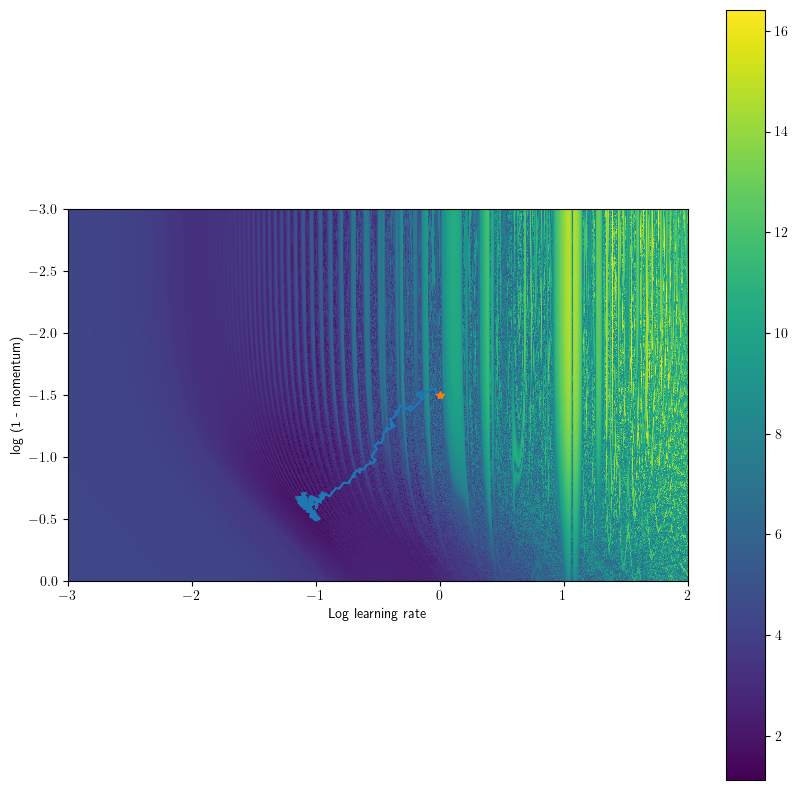

In [ ]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img = img_fn(lrs, moms)
plt.figure(figsize=(10,10))

plt.imshow(img, extent=[-3, 2, 0, -3], interpolation="nearest")
plt.xlabel("Log learning rate")
plt.ylabel("log (1 - momentum)")
plt.colorbar()

log_lrs, one_minus_log_moms = list(zip(*clip_params))
plt.plot(log_lrs[0:1000], one_minus_log_moms[0:1000], "-")
plt.plot(log_lrs[0:1], one_minus_log_moms[0:1], "*")
# lrs = jnp.exp(jnp.asarray(log_lrs))
# moms = 1.0 - jnp.exp(jnp.asarray(one_minus_log_moms))
#plt.xlim(-3, 2)

In [ ]:
lr_grad, mom_grad = list(zip(*grads))
plt.plot(lr_grad)

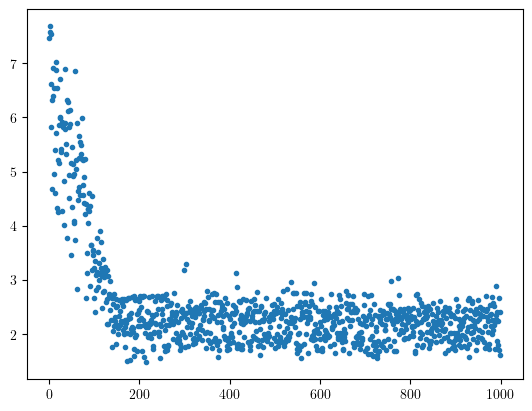

In [ ]:
plt.plot(losses, '.')

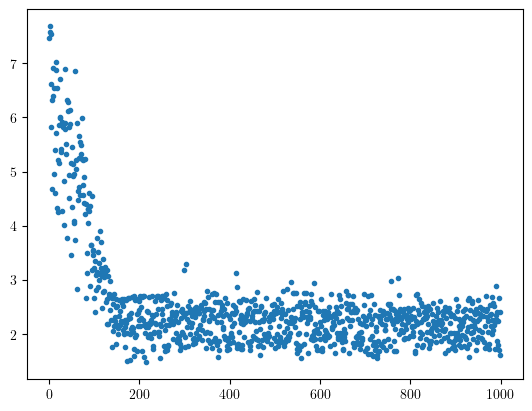

In [ ]:
plt.plot(losses, '.')

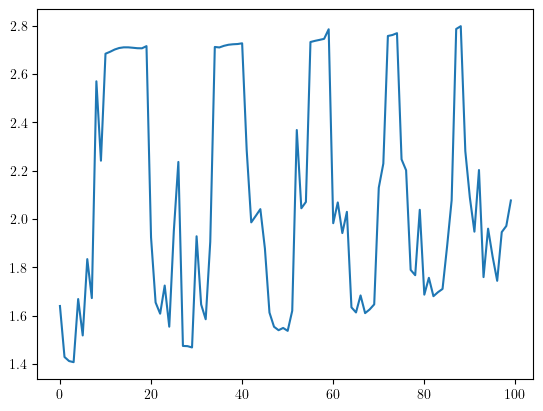

In [ ]:
#ts = jnp.linspace(0.1, 0.1, 100)
ts = jnp.linspace(-1, 1, 100)
ts = jnp.linspace(-0.1, 0.1, 100)
#inp_params = jax.vmap(lambda a, t: (a[0], a[1]+t), in_axes=(None, 0))(outer_params, ts)
#print(inp_params)

plt.plot(jax.vmap(outer_loss, in_axes=((None, 0), ))((outer_params[0], outer_params[1] + ts)))
#plt.plot(jax.vmap(outer_loss, in_axes=((0, None), ))((outer_params[0]+ts, outer_params[1])))

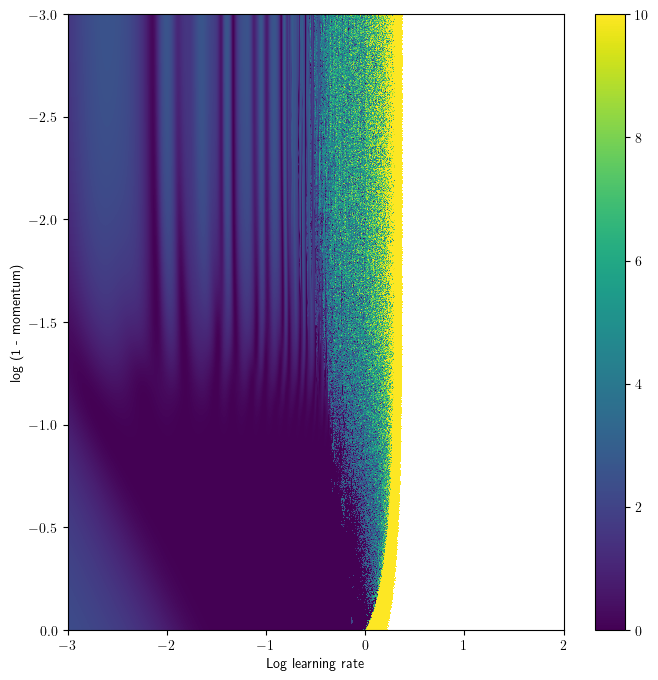

In [ ]:
@jax.jit
def inner_loss(x):
  #return jnp.clip((x[0] + jnp.cos(x[1]))**2 + x[1]**2 + 1., 0, 1000)
  return (x[0] + jnp.cos(x[1]))**2 + x[1]**2 + 1.

value_and_grad_fn = jax.jit(jax.value_and_grad(inner_loss))

@jax.jit
def outer_loss(lr, mom):
  x = jnp.asarray([-4., 1.0])
  v = jnp.asarray([0.0, 0.0])
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
  return loss

lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img_fn = jax.vmap(jax.vmap(outer_loss))

plt.figure(figsize=(8,8))
plt.imshow(jnp.log(img_fn(lrs, moms)), extent=[-3, 2, 0, -3], aspect="auto", interpolation="nearest", vmin=0.0, vmax=10)
plt.xlabel("Log learning rate")
plt.ylabel("log (1 - momentum)")
plt.colorbar()